In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union
from scipy.stats import norm
import os
import glob

In [13]:
link = os.getcwd()
folder = glob.glob('*')
data_link = link + "\\data.csv"
print(data_link)
#rate_link = link + "\\rate.csv"
#risk_link = link + "\\cac40.csv"

C:\Users\milan\OneDrive\Bureau\Projet\data.csv


In [15]:
data = pd.read_csv(data_link, index_col = "Dates", sep = ";", parse_dates = True)
risk = pd.DataFrame(data["SXXR Index"])
rate = pd.DataFrame(data["EONIA Index"])

**Ploting both EONIA and EUROSTOXX600 historical data**

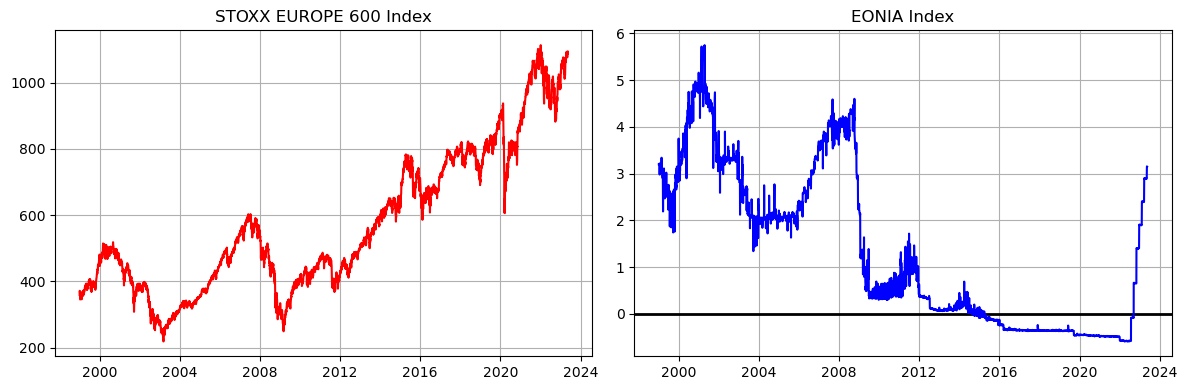

In [16]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(risk, c = "r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(rate, c = "blue")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [17]:
def investment_period(df:pd.DataFrame = risk, y0:Union[int,str]=2000, horizon:int=5, alldata:bool=False):
    """
    parameters:
        - df : The dataframe
        - y0 : The year, if str, or the date in which the investor start to invest
        - horizon : the period of investment.
        - alldata : a boolean variable.
    
    This function is used to get the dataset during an "investment period", denoted by IP.
        - If alldata is True, the IP start from y0 to the end of the dataset
        - If alldata is False, the IP start from y0 to the y0 to y0+horizon-1
        - If y0's type is int, we include the last day of the previous year into the dataset.
    """
    if (alldata == False):
        if type(y0)==int:
            # Only take the last day of past year
            table_investment_JN = pd.DataFrame(df[str(y0-1):str(y0-1)].iloc[-1]).T 
            # The period of investment
            table_investment_J = pd.DataFrame(df[str(y0):str(y0+horizon-1)])
            # concatenate
            table_investment = pd.concat([table_investment_JN, table_investment_J])
        elif type(y0)==str:
            yyyy = int(y0[:4]) # Give the 4 first letters from yyyy-mm-dd
            mm_dd = y0[4:] # Give the remaining -mm-dd
            yyyh_mm_dd = str(yyyy+horizon-1) + mm_dd
            table_investment = pd.DataFrame(df[y0:yyyh_mm_dd])
    else:
        if type(y0)==int:
            # Only take the last day of past year
            table_investment_JN = pd.DataFrame(df[str(y0-1):str(y0-1)].iloc[-1]).T
            table_investment_J = pd.DataFrame(df[str(y0):])
            table_investment = pd.concat([table_investment_JN, table_investment_J])
        elif type(y0)==str:
            table_investment = pd.DataFrame(df[y0:])        
    return table_investment

In [18]:
def returns(df:pd.DataFrame=risk, initial_investment:float=100.0, y0:Union[int,str]=2000,
           horizon:int=5, alldata:bool=False):
    """
    Parameters:
        - df : The DataFrame
        - initial_investment : The initial value that the client deposits 
        - y0 : The moment (year or day) when the client start to invest
        - horizon : The horizon of investment, by defaul 5 years
        - alldata : 
            - if True : Return the whole dataset from y0 to the end
            - if False : Return the y0 + horizon -1 results
    
    This function allows to compute at first, the returns of the risk asset, from y0 to y0+horizon-1 (if alldata = False)
    or from y0 to the end (if alldata = True). Those return will be apply to the initial amount the client choose to invest
    at beginning
    """
    data = investment_period(df, y0, horizon, alldata)
    S0 = float(data.iloc[0])
    stock_returns = [(float(data.iloc[x])/S0 -1) for x in range(len(data)) ]
    stock_returns = np.array(stock_returns).reshape(-1,1)
    data["Risk return"] = initial_investment * (1 + stock_returns)
    data = data.drop(data.columns[0],axis = 1)
    return data

In [62]:
def monetarize(df:pd.DataFrame=rate, initial_investment:float=100.0, y0:Union[int,str]=2000,
           horizon:int=5, alldata:bool=False):
    """
    parameters:
        - df : The dataset
        - initial_investment : The initial value that the client deposits 
        - y0 : The moment (year or day) when the client start to invest
        - horizon : The horizon of investment, by defaul 5 years
        - alldata : 
            - if True : Return the whole dataset from y0 to the end
            - if False : Return the y0 + horizon -1 results
            
    This function allows to compute the investment to the safe asset (bond), by starting with the amount the investor
    paid.
    """
    data = investment_period(df, y0, horizon, alldata)
    bond_rate = [x for x in data.iloc[:,0]]
    bond_rate = np.array(bond_rate).reshape(-1,1)
    bond = []
    compteur = 0
    for i in bond_rate:
        if compteur == 0:
            bond.append(initial_investment)
        else:
            investment = float(bond[compteur-1] * (1 + i/(365*100)))
            bond.append(investment)
        compteur += 1
    data["RiskFree return"] = bond
    data = data.drop(data.columns[0], axis = 1)
    return data

<AxesSubplot:>

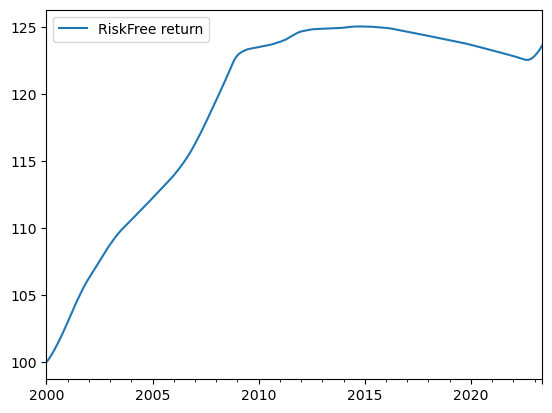

In [63]:
monetarize(alldata = True).plot()

<AxesSubplot:>

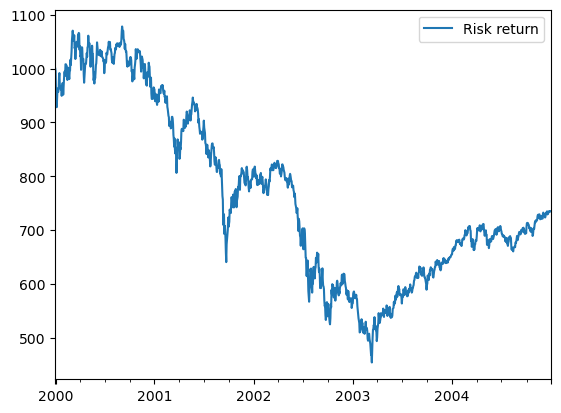

In [20]:
returns(initial_investment = 1000).plot()